In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchvision.transforms.functional import to_tensor
from torch.amp import autocast, GradScaler

import os
import numpy as np
import subprocess
from PIL import Image
import shutil

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
device = 'cuda'

In [3]:
def read_pickle(path) -> torch.tensor:
    temp = torch.load(path)
    return temp['video'], temp['label']

def pickle_files_path_list(path) -> list:
    path_list = []
    for top, dirs, files in os.walk(path):
        for nm in files:
            path_list.append(os.path.join(top, nm))
    return path_list

In [6]:
def show_sequence(sequence, NUM_FRAMES):
    columns = 4
    rows = (NUM_FRAMES + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        frames = sequence[j].permute(1,2,0).numpy()
        frames = frames/ frames.max()
        plt.imshow(frames)

    plt.show()

In [8]:
def save_checkpoint(state, filename="checkpoint.pth"):
    """Save model and optimizer state to a file."""
    torch.save(state, filename)

def load_checkpoint(filename="checkpoint.pth"):
    """Load model and optimizer state from a file."""
    checkpoint = torch.load(filename)
    return checkpoint

In [11]:
# Paths to your pickle files - 
# train_data :
train_paths = pickle_files_path_list('/kaggle/input/include-interpolated-cv/ISL_pickle/Train_data')
# test data :
test_paths = pickle_files_path_list('/kaggle/input/include-interpolated-cv/ISL_pickle/Test_data')

In [32]:
# showing one video
path_list = train_paths
for path in path_list:
    X,y = read_pickle(path=path)
    break

<ipython-input-3-7543838de8f6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


In [33]:
temp = X.to(torch.float32)

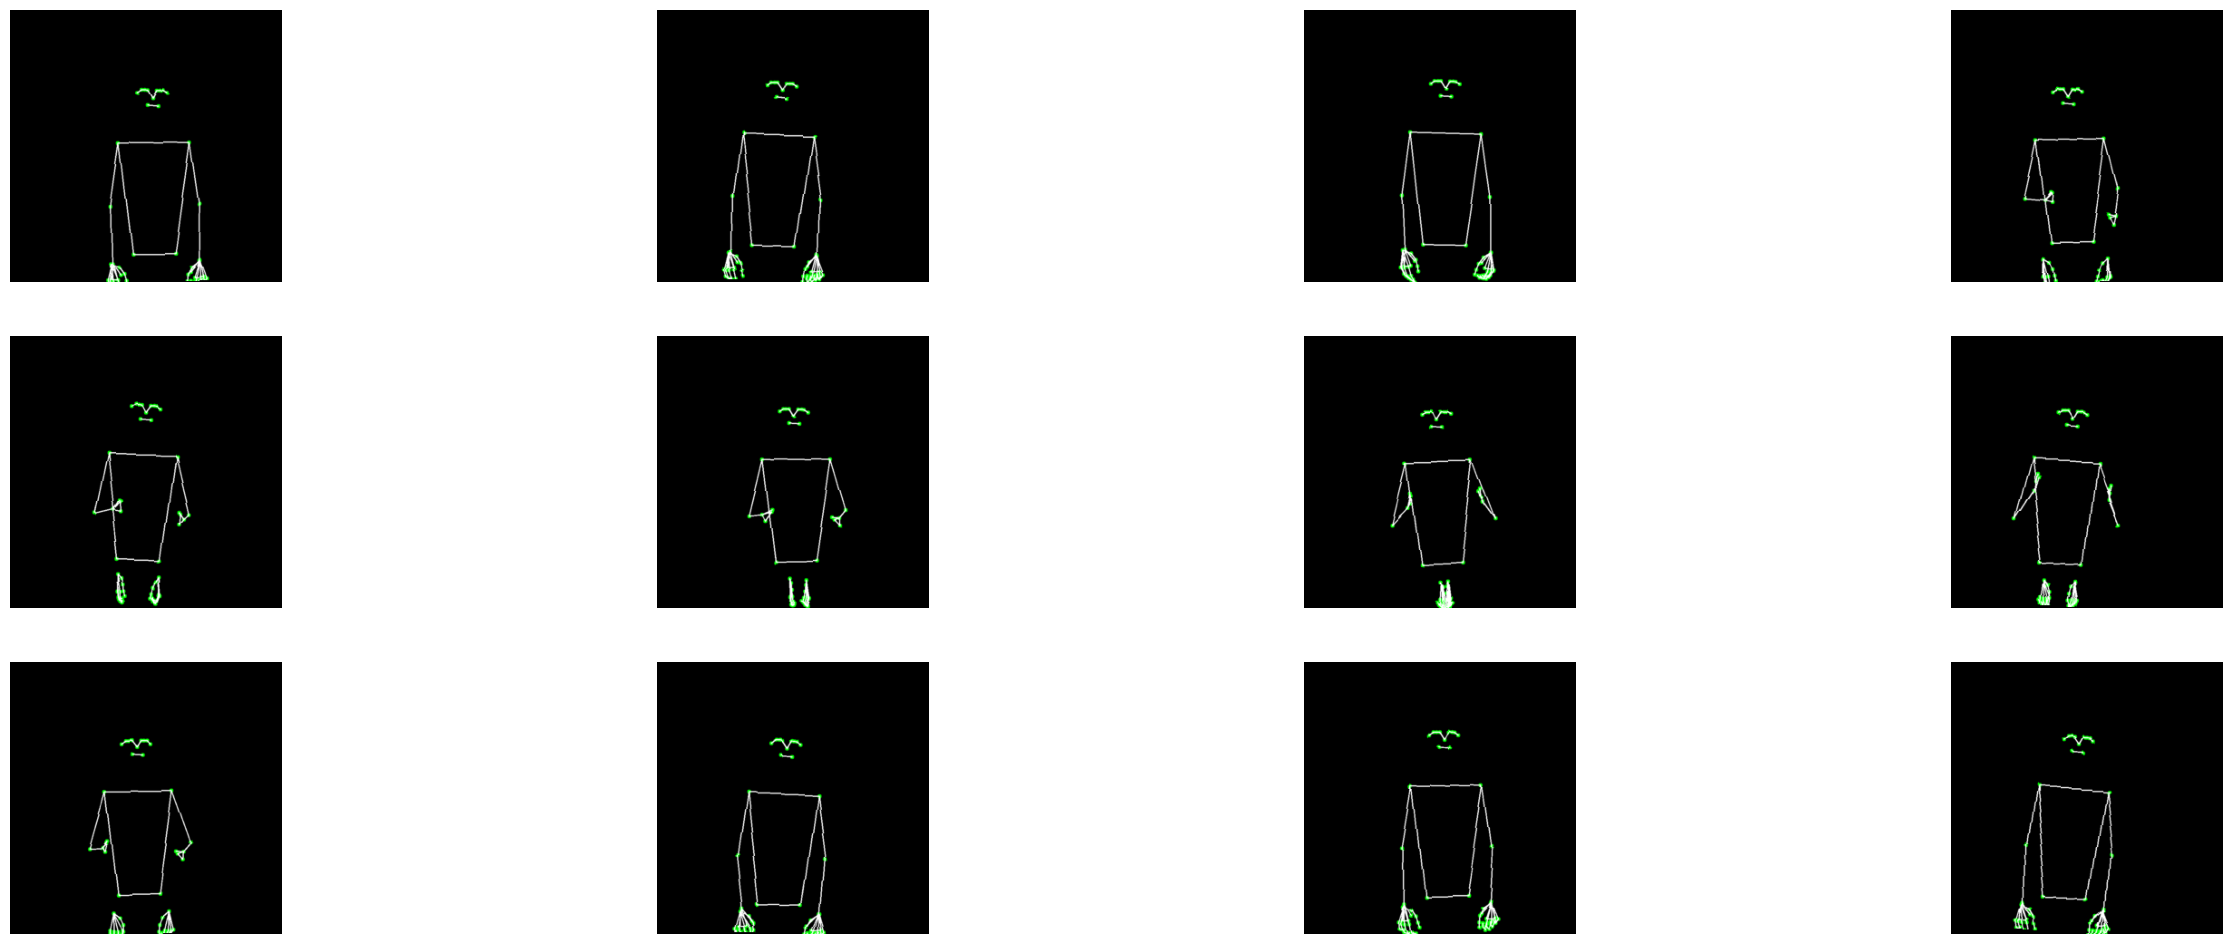

In [34]:
show_sequence(temp[0],12)

In [17]:
# Function to save processed data
def pickle_data(X, y, n, path):
    tensor_data = {
        'video': X.to(torch.float16),  # Convert to half-precision for smaller storage
        'label': y
    }
    os.makedirs(path, exist_ok=True)  # Ensure the save directory exists
    torch.save(tensor_data, os.path.join(path, f'tensor_{n}.pt'))

In [18]:
preprocess_frame = transforms.Compose([
    transforms.RandomCrop((680,1208)),
    transforms.CenterCrop((680,680)),
    transforms.Resize((300,300)),
    transforms.RandomRotation((-5,5))
])

In [19]:
# Function to preprocess video tensors
def apply_transforms(tensor: torch.Tensor) -> torch.Tensor:
    # Reshape to process individual frames
    batch_size, num_frames, channels, height, width = tensor.shape
    tensor = tensor.view(-1, channels, height, width)  # Flatten to 4D: [batch_size*num_frames, 3, H, W]
    processed_frames = torch.stack([preprocess_frame(frame) for frame in tensor])
    return processed_frames.view(batch_size, num_frames, channels, *processed_frames.shape[-2:])

In [21]:
# Function to load, resize, and save tensors
def resize_tensors(paths, path_to_save):
    for n, path in enumerate(paths):
        # Load tensor from disk
        video , label = read_pickle(path)
        video = video.to(torch.float32)
        
        video = apply_transforms(video)
        
        # Save processed tensor
        pickle_data(video, label, n, path_to_save)

In [22]:
resize_tensors(train_paths,"/kaggle/working/include-interpolated-cv-300p-double-madness/ISL_pickle/Train_data")
resize_tensors(test_paths,"/kaggle/working/include-interpolated-cv-300p-double-madness/ISL_pickle/Test_data")

<ipython-input-21-645f16273ec4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)
